In [1]:
import numpy as np
import torch
from torch import nn

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import jaccard_score

In [2]:
def calculate_iou(pred_list, target_list, num_classes=17):
    res_list = []
    pred_as_mask_list = []
    
    for preds, target in zip(pred_list, target_list):
        # preds - (num_classes, H, W)
        preds = preds.detach()
        # target - (H, W)
        target = target.detach()

        preds = nn.functional.softmax(preds, dim=0)
        preds = torch.argmax(preds, dim=0)
        pred_as_mask_list.append(preds)
        
        preds_one_hoted = torch.nn.functional.one_hot(preds, num_classes).view(-1, num_classes).cpu()
        target_one_hoted = torch.nn.functional.one_hot(target, num_classes).view(-1, num_classes).cpu()
        res = jaccard_score(target_one_hoted, preds_one_hoted, average=None, zero_division=1)
        res_list.append(
            res
        )
    
    res_np = np.stack(res_list)
    #res_np = res_np.mean(axis=0)
    return res_np, pred_as_mask_list


def dice_loss(preds, ground_truth, eps=1e-5, dim=None, use_softmax=False, softmax_dim=1):
    """
    Computes Dice loss according to the formula from:
    V-Net: Fully Convolutional Neural Networks forVolumetric Medical Image Segmentation
    Link to the paper: http://campar.in.tum.de/pub/milletari2016Vnet/milletari2016Vnet.pdf
    Parameters
    ----------
    preds : tf.Tensor
        Predicted probabilities.
    ground_truth : tf.Tensor
        Ground truth labels.
    eps : float
        Used to prevent division by zero in the Dice denominator.
    axes : list
        Defines which axes the dice value will be computed on. The computed dice values will be averaged
        along the remaining axes. If None, Dice is computed on an entire batch.
    Returns
    -------
    tf.Tensor
        Scalar dice loss tensor.
    """
    ground_truth = ground_truth.float().to(device=preds.device)
    
    if use_softmax:
        preds = nn.functional.softmax(preds, dim=softmax_dim)
    
    numerator = preds * ground_truth
    numerator = torch.sum(numerator, dim=dim)

    p_squared = torch.square(preds)
    p_squared = torch.sum(p_squared, dim=dim)
    # ground_truth is not squared to avoid unnecessary computation.
    # 0^2 = 0
    # 1^2 = 1
    g_squared = torch.sum(torch.square(ground_truth), dim=dim)
    denominator = p_squared + g_squared + eps

    dice = 2 * numerator / denominator
    return 1 - dice


def clear_metric_calculation(final_metric, target_t, pred_t, num_classes=17, using_pred=False):
    """
    
    Parameters
    ----------
    final_metric: torch.Tensor
        Tensor with shape (N, C)
    target_t: torch.Tensor or list
        Tensor with shape (N, 1, H, W)
    pred_t: torch.Tensor or list
        Tensor with shape (N, 1, H, W)
    
    """
    # For each image
    final_metric_dict = dict([
        (str(i), []) for i in range(num_classes)
    ])
    for metric_s, target_t_s, pred_t_s in zip(final_metric, target_t, pred_t):
        unique_indx_target = torch.unique(target_t_s.long())
        unique_indx_pred = None
        if using_pred:
            if isinstance(pred_t_s, np.ndarray):
                pred_t_s = torch.from_numpy(pred_t_s)
            unique_indx_pred = torch.unique(pred_t_s.long())
        for i in range(num_classes):
            if i in unique_indx_target or \
                    (unique_indx_pred is not None and i in unique_indx_pred):
                final_metric_dict[str(i)].append(metric_s[i])
    
    mean_per_class_metric = [
        sum(final_metric_dict[str(i)]) / len(final_metric_dict[str(i)])
        if len(final_metric_dict[str(i)]) != 0
        else 0.0
        for i in range(num_classes)
    ] 
    mean_metric = sum(mean_per_class_metric) / len(mean_per_class_metric)
    return mean_per_class_metric, mean_metric


In [3]:
def preds2onehot(preds):
    preds = torch.from_numpy(preds)
    preds = nn.functional.softmax(preds, dim=1)
    preds = torch.argmax(preds, dim=1)
    
    one_hotted_tensor = torch.nn.functional.one_hot(
        preds, 17 # Num classes
    )
    # (N, H, W, C) --> (N, C, H, W)
    one_hotted_tensor = one_hotted_tensor.permute(0, -1, 1, 2)
    return preds.numpy(), one_hotted_tensor.numpy()

In [4]:
# Load - cnn
loaded_cnn_one_hot_target = np.load('cnn/target_one_hotted_tensor.npy')
loaded_cnn_target = np.argmax(loaded_cnn_one_hot_target, axis=1)

loaded_cnn_logits_preds = np.load('cnn/pred_tensor.npy')
loaded_cnn_preds, loaded_cnn_one_hot_preds = preds2onehot(loaded_cnn_logits_preds)

# Load - pixel-strategy
loaded_pixel_one_hot_target = np.load('pixel_strategy/target_one_hotted_tensor.npy') 
loaded_pixels_target = np.argmax(loaded_pixel_one_hot_target, axis=1)

loaded_pixel_logits_preds = np.load('pixel_strategy/pred_tensor.npy')
loaded_pixel_preds, loaded_pixel_one_hot_preds = preds2onehot(loaded_pixel_logits_preds)

In [44]:
def create_big_image(tensor):
    shape = tensor.shape
    tensor = np.concatenate([
        t_s.reshape(1, 17, 512, 512)
        for t_s in tensor
    ], axis=-1)
    return tensor

In [45]:
# Load - cnn
loaded_cnn_one_hot_target = create_big_image(loaded_cnn_one_hot_target)
loaded_cnn_target = np.argmax(loaded_cnn_one_hot_target, axis=1)

loaded_cnn_logits_preds = create_big_image(np.load('cnn/pred_tensor.npy'))
loaded_cnn_preds, loaded_cnn_one_hot_preds = preds2onehot(loaded_cnn_logits_preds)

# Load - pixel-strategy
loaded_pixel_one_hot_target = create_big_image(np.load('pixel_strategy/target_one_hotted_tensor.npy') )
loaded_pixels_target = np.argmax(loaded_pixel_one_hot_target, axis=1)

loaded_pixel_logits_preds = create_big_image(np.load('pixel_strategy/pred_tensor.npy'))
loaded_pixel_preds, loaded_pixel_one_hot_preds = preds2onehot(loaded_pixel_logits_preds)

In [46]:
loaded_cnn_one_hot_target.shape

(1, 17, 512, 19968)

In [64]:
dice_loss_val = dice_loss(
    torch.from_numpy(loaded_pixel_logits_preds), 
    torch.from_numpy(loaded_pixel_one_hot_target), 
    dim=[0, 2, 3], use_softmax=True, softmax_dim=1
)
metric, pred_as_mask_list = calculate_iou(
    torch.from_numpy(loaded_pixel_logits_preds), 
    torch.from_numpy(loaded_pixels_target)
)

mean_per_class_metric, mean_metric = clear_metric_calculation(
    metric, torch.from_numpy(loaded_cnn_target), pred_as_mask_list,
    using_pred=False
)

In [65]:
dice_loss_val

tensor([0.1023, 0.1017, 0.0281, 0.1491, 0.5212, 0.7105, 0.3116, 0.2430, 0.1060,
        0.2561, 0.1982, 0.0998, 0.0628, 0.0614, 0.1127, 0.9993, 0.3112])

In [66]:
mean_per_class_metric, mean_metric

([0.75901967820683,
  0.775409225173481,
  0.9299254258272317,
  0.6752405391924133,
  0.2987461060545413,
  0.15136932037171855,
  0.4732840943203853,
  0.5629970789674832,
  0.7874051914447453,
  0.5787777099571605,
  0.621362248937535,
  0.7645417497827763,
  0.8520044309854354,
  0.8471095345317015,
  0.7566236939516056,
  0.0,
  0.4747069194840546],
 0.6063837027758293)

In [68]:
dice_loss_val = dice_loss(
    torch.from_numpy(loaded_cnn_logits_preds), 
    torch.from_numpy(loaded_cnn_one_hot_target), 
    dim=[0, 2, 3], use_softmax=True, softmax_dim=1
)
metric, pred_as_mask_list = calculate_iou(
    torch.from_numpy(loaded_cnn_logits_preds), 
    torch.from_numpy(loaded_cnn_target)
)

mean_per_class_metric, mean_metric = clear_metric_calculation(
    metric, torch.from_numpy(loaded_cnn_target), pred_as_mask_list,
    using_pred=False
)

In [69]:
dice_loss_val

tensor([0.1029, 0.1101, 0.0284, 0.1478, 0.5420, 0.6724, 0.3178, 0.3731, 0.1624,
        0.2190, 0.2159, 0.0883, 0.0639, 0.0530, 0.1263, 0.9998, 0.3378])

In [70]:
mean_per_class_metric, mean_metric

([0.758142558919901,
  0.7600446535977904,
  0.9296820146927574,
  0.6803178184315072,
  0.2754552724214969,
  0.17648912469953684,
  0.47486850689064664,
  0.4231668677531722,
  0.6890377437426816,
  0.614471460502644,
  0.5956617451062696,
  0.7900304433472333,
  0.8448860623668532,
  0.8678943053541023,
  0.7430654205607476,
  0.0,
  0.45331130021530536],
 0.592736782270744)

In [75]:
dice_loss_val = dice_loss(
    torch.from_numpy(loaded_cnn_logits_preds), 
    torch.from_numpy(loaded_pixel_one_hot_preds), 
    dim=[0, 2, 3], use_softmax=True, softmax_dim=1
)
metric, pred_as_mask_list = calculate_iou(
    torch.from_numpy(loaded_cnn_logits_preds), 
    torch.from_numpy(loaded_pixel_preds)
)

mean_per_class_metric, mean_metric = clear_metric_calculation(
    metric, torch.from_numpy(loaded_pixel_preds), pred_as_mask_list
)

In [76]:
dice_loss_val, dice_loss_val.mean()

(tensor([0.0777, 0.0894, 0.0213, 0.1496, 0.3487, 0.3415, 0.1821, 0.2562, 0.1073,
         0.1301, 0.1379, 0.1078, 0.0610, 0.0578, 0.1073, 0.7397, 0.1912]),
 tensor(0.1828))

In [77]:
mean_per_class_metric, mean_metric

([0.8163852351531572,
  0.7993526305635544,
  0.9459798625163024,
  0.6949844881075491,
  0.42296329421079254,
  0.4266729966727573,
  0.6458945043845099,
  0.5493131782753006,
  0.7676741108931193,
  0.7214938934013162,
  0.721837776343602,
  0.7648426116520572,
  0.8542086029913053,
  0.8654308056652743,
  0.7919697862885202,
  0.12030029109851387,
  0.6220795535607194],
 0.6783166836340206)

In [78]:
metric.mean(axis=0), metric.mean(axis=0).mean()

(array([0.81638524, 0.79935263, 0.94597986, 0.69498449, 0.42296329,
        0.426673  , 0.6458945 , 0.54931318, 0.76767411, 0.72149389,
        0.72183778, 0.76484261, 0.8542086 , 0.86543081, 0.79196979,
        0.12030029, 0.62207955]),
 0.6783166836340206)

In [79]:
np.asarray(dice_loss_val.tolist() + [dice_loss_val.mean()])

array([0.07770324, 0.08939719, 0.0213424 , 0.14964491, 0.34869599,
       0.34153891, 0.18213189, 0.25621551, 0.10731047, 0.13006204,
       0.13786805, 0.10783106, 0.06100631, 0.05775619, 0.10732871,
       0.73970938, 0.19122571, 0.18275106])

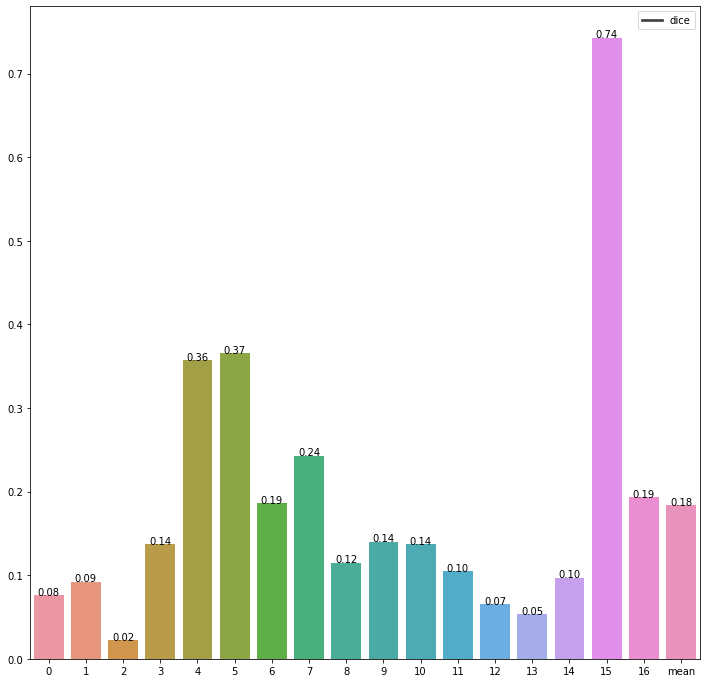

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))

sns.barplot(
    x=list(map(str, range(17))) + ["mean"], y=np.asarray(dice_loss_val.tolist() + [dice_loss_val.mean()]) 
)
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

show_values_on_bars(ax)
plt.legend(['dice'])

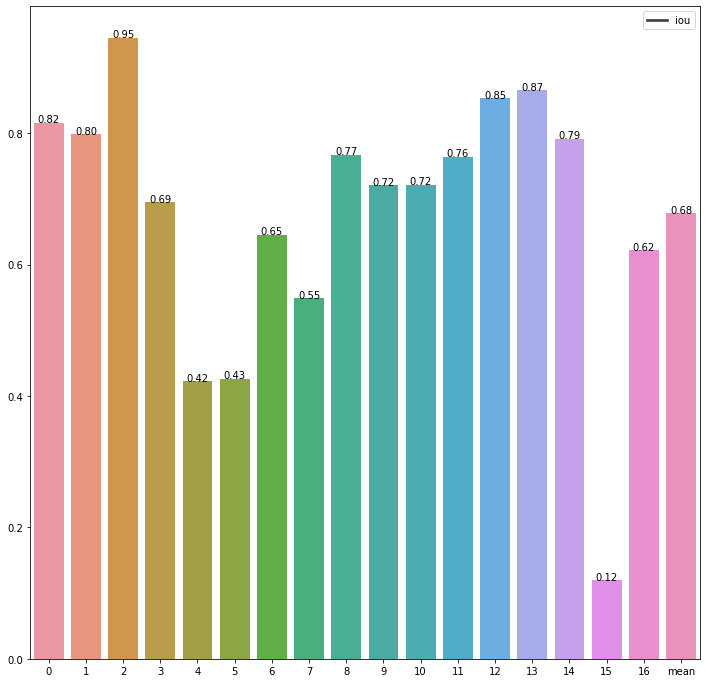

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))

sns.barplot(
    x=list(map(str, range(17))) + ["mean"], y=np.asarray(metric.mean(axis=0).tolist() + [metric.mean()]) 
)
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

show_values_on_bars(ax)
plt.legend(['iou'])

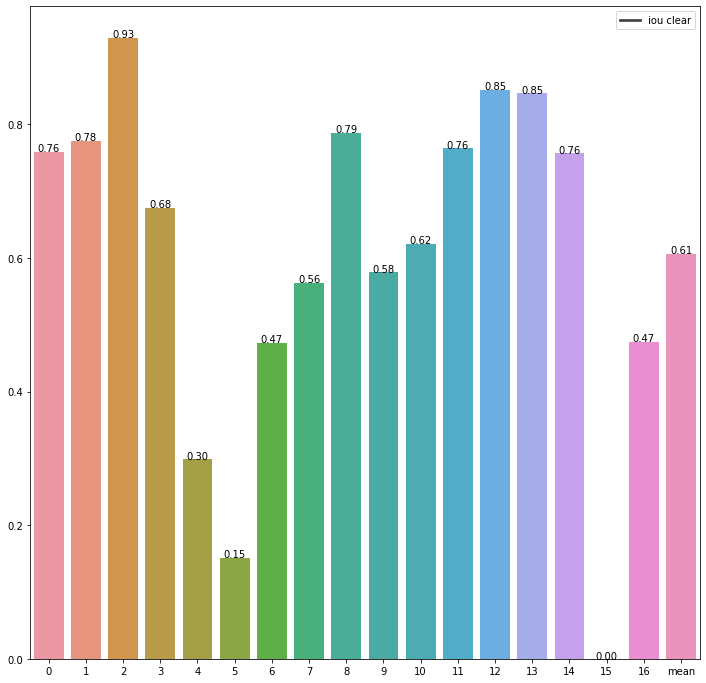

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))

sns.barplot(
    x=list(map(str, range(17))) + ["mean"], y=np.asarray(mean_per_class_metric + [mean_metric]) 
)
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

show_values_on_bars(ax)
plt.legend(['iou clear'])

In [82]:
dice_loss_val = dice_loss(
    torch.from_numpy(loaded_pixel_logits_preds), 
    torch.from_numpy(loaded_cnn_one_hot_preds), 
    dim=[0, 2, 3], use_softmax=True, softmax_dim=1
)
metric, pred_as_mask_list = calculate_iou(
    torch.from_numpy(loaded_pixel_logits_preds), 
    torch.from_numpy(loaded_cnn_preds)
)

mean_per_class_metric, mean_metric = clear_metric_calculation(
    metric, torch.from_numpy(loaded_cnn_preds), pred_as_mask_list
)

In [73]:
dice_loss_val, dice_loss_val.mean()

(tensor([0.0765, 0.0923, 0.0226, 0.1374, 0.3571, 0.3657, 0.1862, 0.2430, 0.1150,
         0.1402, 0.1371, 0.1047, 0.0657, 0.0534, 0.0970, 0.7433, 0.1930]),
 tensor(0.1841))

In [74]:
mean_per_class_metric, mean_metric

([0.8163852351531572,
  0.7993526305635544,
  0.9459798625163024,
  0.6949844881075491,
  0.42296329421079254,
  0.4266729966727573,
  0.6458945043845099,
  0.5493131782753006,
  0.7676741108931193,
  0.7214938934013162,
  0.721837776343602,
  0.7648426116520572,
  0.8542086029913053,
  0.8654308056652743,
  0.7919697862885202,
  0.12030029109851387,
  0.6220795535607194],
 0.6783166836340206)

In [51]:
metric.mean(axis=0), metric.mean(axis=0).mean()

(array([0.674472  , 0.46706221, 0.62363081, 0.7632359 , 0.57222331,
        0.55100868, 0.74690617, 0.44679824, 0.64399825, 0.73971335,
        0.23522853, 0.82067467, 0.59289507, 0.74157825, 0.77343722,
        0.82866668, 0.72597082]),
 0.6439705972197436)